## Data Cleaning

First import necessary packages for cleaning and anything else that is needed.

In [1]:
import pandas as pd
import numpy as np
import os
from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt

pysqldf = lambda q: sqldf(q, globals())
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Loading data into dataframes

In [2]:
Bommoviegross = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
BomGross = pd.DataFrame(Bommoviegross)

imdbname = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
imdbName = pd.DataFrame(imdbname)

imdbtitlea = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
imdbTitleAkas = pd.DataFrame(imdbtitlea)

imdbtitleb = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
imdbTitleBasic = pd.DataFrame(imdbtitleb)

imdbtitlec = pd.read_csv('./zippedData/imdb.title.crew.csv.gz')
imdbTitleCrew = pd.DataFrame(imdbtitlec)

imdbtitlep = pd.read_csv('./zippedData/imdb.title.principals.csv.gz')
imdbTitlePrin = pd.DataFrame(imdbtitlep)

imdbtitler = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')
imdbTitleRat = pd.DataFrame(imdbtitler)

rtmov = pd.read_csv('./zippedData/rt.movie_info.tsv.gz', sep='\t')
rtmovie = pd.DataFrame(rtmov)

rtrev = pd.read_csv('./zippedData/rt.reviews.tsv.gz', sep='\t', encoding= 'unicode_escape')
rtreview = pd.DataFrame(rtrev)

tmdb = pd.read_csv('./zippedData/tmdb.movies.csv.gz')
tmdbmov = pd.DataFrame(tmdb)

tnm = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')
tnmmov = pd.DataFrame(tnm)

Functions For notebook

In [3]:
def BustinOut(Dataframe, Column, DictionaryOfNames):
    row_count = 0
    
    Names = DictionaryOfNames.values()
    DictionaryOfNames_List = {}
    for name in Names:
        DictionaryOfNames_List[name] = []
    
    for row in Dataframe[Column]:
        for x in row:
            for k,v in DictionaryOfNames_List.items():
                if x == k:
                    v.append(1)
        for k,v in DictionaryOfNames_List.items():
            if len(v) <= row_count:
                v.append(0)
        row_count += 1
    
    for k,v in DictionaryOfNames_List.items():
        Dataframe[k] = v
    
    return Dataframe

Cleaning up Tables

In [4]:
#This table is going to be used for Review/Ratings for directors/writers (IMDB)

#Joining imdb tables to make a master table
q = '''SELECT *
       FROM imdbTitleBasic
       LEFT JOIN imdbTitleRat
       USING (tconst)
       Left JOIN imdbTitleCrew
       USING (tconst)
       ;
    '''
imdbMaster = pysqldf(q)

#cleaning up directors and writers columns, putting in the actual names for imdbMaster table
imdbMaster['directors'] = imdbMaster['directors'].astype(str)
imdbMaster['writers'] = imdbMaster['writers'].astype(str)
imdbMaster['directors'] = imdbMaster['directors'].map(lambda x: x.split(','))
imdbMaster['writers'] = imdbMaster['writers'].map(lambda x: x.split(','))
All_names = imdbName.set_index('nconst')['primary_name'].to_dict()
DirectorNamesList = []
for entry in imdbMaster['directors']:
    DirectorNamesList.append([All_names.get(item,item) for item in entry])
imdbMaster['Director_Names'] = DirectorNamesList
WritersNamesList = []
for entry in imdbMaster['writers']:
    WritersNamesList.append([All_names.get(item,item) for item in entry])
imdbMaster['Writers_Names'] = WritersNamesList

#Some Writers have ['None'] so putting nan values in so when I add up the writers it wont think None is an actual
#Writer
imdbMaster = imdbMaster.applymap(lambda x: np.nan if x == ['None'] else x)

#Making new rows of number of directors and number of writers
imdbMaster['Num_of_Directors'] = imdbMaster['Director_Names'].map(lambda x: len(x) if type(x)==list else 0)
imdbMaster['Num_of_Writers'] = imdbMaster['Writers_Names'].map(lambda x: len(x) if type(x)==list else 0)

#Drop Anything with a missing rating
imdbMaster = imdbMaster.dropna(subset=['averagerating'])

In [20]:
#Cleaning up tnmfile
#This table is going to be used for Budget/Gross Comparison and during the season

#Dropping columns with $0 for domestic_gross and worldwide_gross (only 367 out of 5782 data entries: ~5%)
df_to_drop1 = tnmmov.loc[(tnmmov['domestic_gross'] == '$0') & (tnmmov['worldwide_gross'] == '$0')] #throw these out
newtnm = pd.concat([tnmmov,df_to_drop1]).drop_duplicates(keep=False)

#Making production_budget, domestic_gross and worldwide_gross values to int instead of string
newtnm['production_budget'] = newtnm.production_budget.map(lambda x: int(x.replace('$','').replace(',','')))
newtnm['domestic_gross'] = newtnm.domestic_gross.map(lambda x: int(x.replace('$','').replace(',','')))
newtnm['worldwide_gross'] = newtnm.worldwide_gross.map(lambda x: int(x.replace('$','').replace(',','')))

#Making a new column for Profit
newtnm['Profit'] = newtnm['worldwide_gross'] - newtnm['production_budget']

#Dec 31 is a placeholder date (only 74 entries, lets throw out instead of looking up each movie date)
#Total thrown out is 7.62% of original data
df_to_drop2 = newtnm[newtnm.release_date.map(lambda x: x.startswith('Dec 31,'))]
newtnmForDateComp = pd.concat([newtnm,df_to_drop2]).drop_duplicates(keep=False)
#Lets make the release month and release year into new columns, will be easier to work with
newtnmForDateComp['Release_Month'] = newtnmForDateComp['release_date'].map(lambda x: x[0:3])
newtnmForDateComp['Release_Year'] = newtnmForDateComp['release_date'].map(lambda x: x[-4:])
#Drop the id and release_date column to make it look nicer
newtnmForDateComp = newtnmForDateComp.drop(columns = ['id','release_date'])

In [6]:
#Cleaning up TMDB File
#This table is going to be used for Genre/Popularity comparison

#First drop the unnamed first column
tmdbmov = tmdbmov.drop(tmdbmov.columns[0], axis = 1)
#Lets drop exact duplicate columns
newtmdb = tmdbmov.drop_duplicates()
#Dropping rows that don't have genre values, because that's what we're interested in for this dataframe
df_to_drop3 = newtmdb[newtmdb.genre_ids == '[]']
newtmdb = pd.concat([newtmdb,df_to_drop3]).drop_duplicates(keep=False)

In [7]:
#Continuing to clean up TMDB File
#Adding a new column that'll have the actual GenreNames in it

newGenreKey = {'28':'Action', '12':'Adventure', '16':'Animation', '35':'Comedy', '80':'Crime', '99':'Documentary',
               '18':'Drama', '10751':'Family', '14':'Fantasy', '36':'History', '27':'Horror', '10402':'Music',
               '9648':'Mystery', '10749':'Romance', '878':'Science Fiction', '10770':'TV Movie', '53':'Thriller',
               '10752':'War', '37':'Western'}
newtmdb['genre_ids'] = newtmdb['genre_ids'].map(lambda x: 
                                                     x.replace('[','').replace(']','').replace(' ','').split(','))
GenreNamesList = []
for entry in newtmdb['genre_ids']:
    GenreNamesList.append([newGenreKey.get(item,item) for item in entry])
newtmdb['Genre_Names'] = GenreNamesList

#Bringing out the Genre_Names column and making each genre a different column
BustinOut(newtmdb, 'Genre_Names', newGenreKey)

#Dropping genre_ids column and id, make it look neater
newtmdb = newtmdb.drop(columns = ['genre_ids', 'id'])

# Ploting the Data

First Question: What Genre is the most popular?

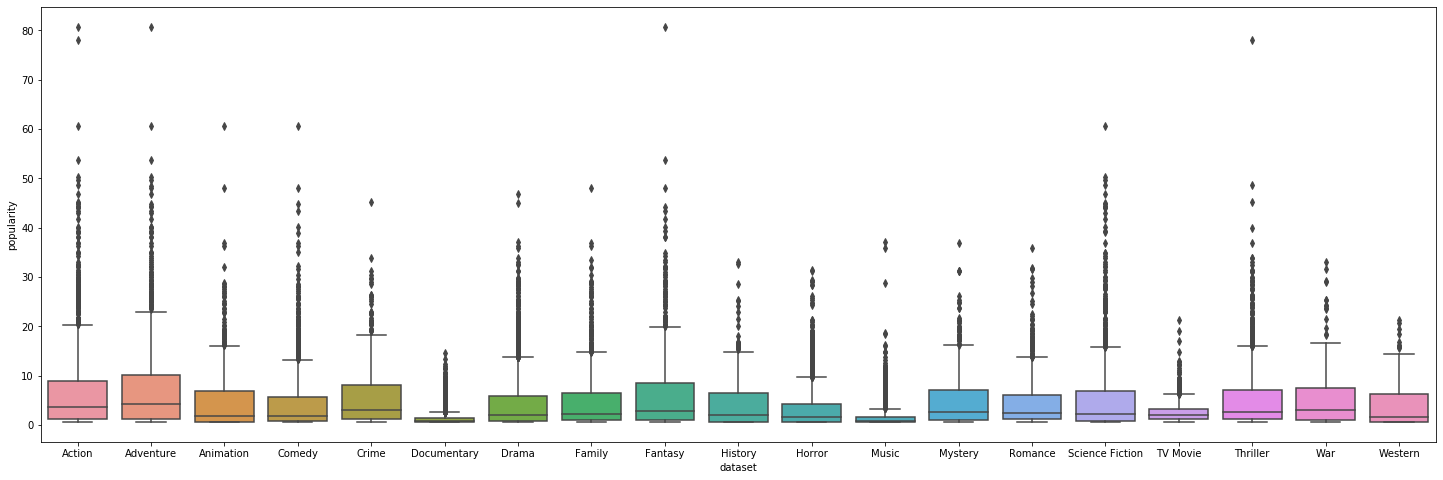

In [8]:
ListOfGenres = list(newGenreKey.values())
GenrePopTables = {}
for genre in ListOfGenres:
    GenrePopTables[genre] = newtmdb[newtmdb[genre]==1]
ActionData = GenrePopTables['Action']
AdventureData = GenrePopTables['Adventure']
AnimationData = GenrePopTables['Animation']
ComedyData = GenrePopTables['Comedy']
CrimeData = GenrePopTables['Crime']
DocumentaryData = GenrePopTables['Documentary']
DramaData = GenrePopTables['Drama']
FamilyData = GenrePopTables['Family']
FantasyData = GenrePopTables['Fantasy']
HistoryData = GenrePopTables['History']
HorrorData = GenrePopTables['Horror']
MusicData = GenrePopTables['Music']
MysteryData = GenrePopTables['Mystery']
RomanceData = GenrePopTables['Romance']
ScienceFictionData = GenrePopTables['Science Fiction']
TVMovieData = GenrePopTables['TV Movie']
ThrillerData = GenrePopTables['Thriller']
WarData = GenrePopTables['War']
WesternData = GenrePopTables['Western']


concatenated = pd.concat([ActionData.assign(dataset='Action'), AdventureData.assign(dataset='Adventure'),
                         AnimationData.assign(dataset='Animation'), ComedyData.assign(dataset='Comedy'),
                         CrimeData.assign(dataset='Crime'), DocumentaryData.assign(dataset='Documentary'),
                         DramaData.assign(dataset='Drama'), FamilyData.assign(dataset='Family'),
                         FantasyData.assign(dataset='Fantasy'), HistoryData.assign(dataset='History'),
                         HorrorData.assign(dataset='Horror'), MusicData.assign(dataset='Music'),
                         MysteryData.assign(dataset='Mystery'), RomanceData.assign(dataset='Romance'),
                         ScienceFictionData.assign(dataset='Science Fiction'),
                         TVMovieData.assign(dataset='TV Movie'),
                         ThrillerData.assign(dataset='Thriller'), WarData.assign(dataset='War'),
                         WesternData.assign(dataset='Western')])

fig1, ax1 = plt.subplots(figsize = (25,8))
sns.boxplot(x='dataset',y='popularity',data=concatenated, ax = ax1)


Second Question: Is there a time of year movies make more money?

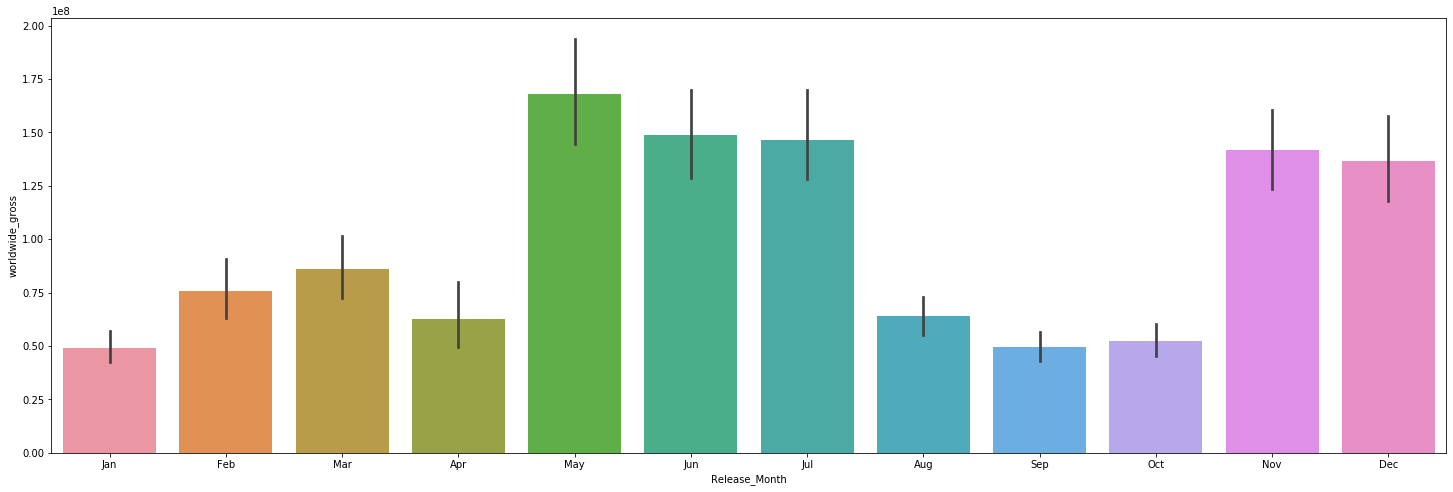

In [9]:
fig2, ax2 = plt.subplots(figsize = (25,8))
sns.barplot(x='Release_Month', y='worldwide_gross',data=newtnmForDateComp, ax=ax2,
           order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

Third Question: Should there be a cap on budget?

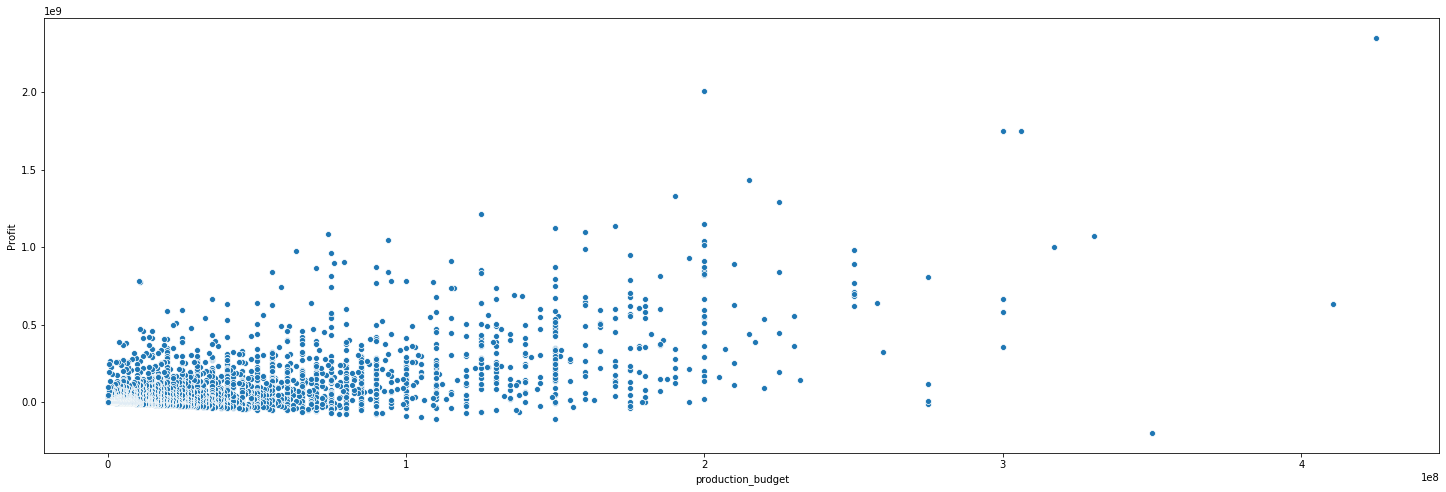

In [22]:
#Maybe make a new column for revenue?
fig3, ax3 = plt.subplots(figsize=(25,8))
sns.scatterplot(x='production_budget',y='Profit',data=newtnm,ax=ax3)

In [11]:
newtnm.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


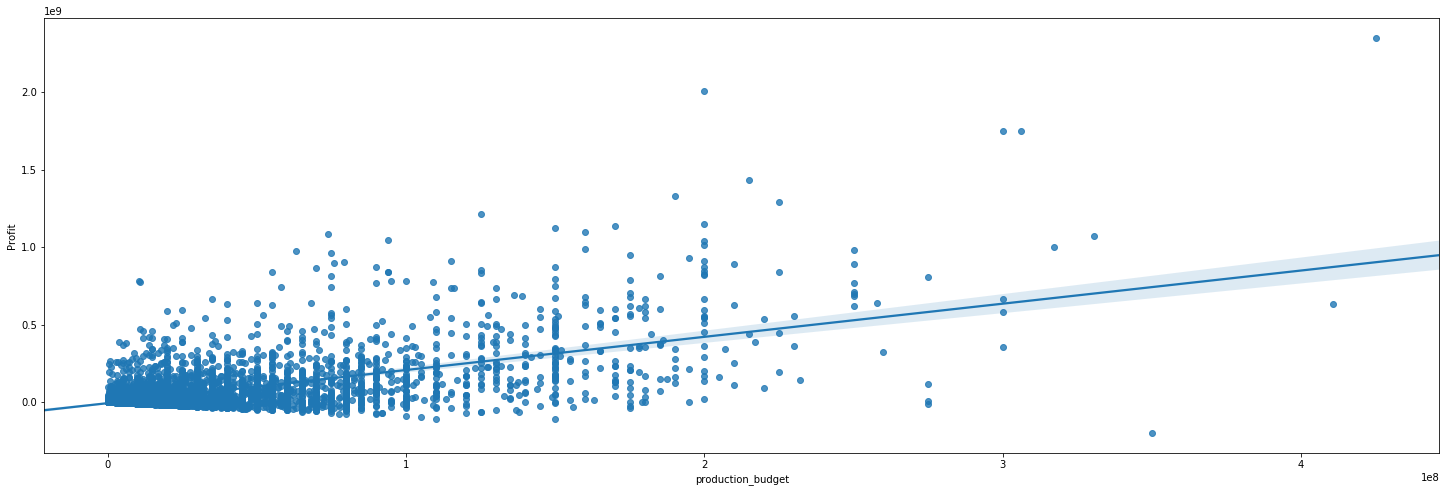

In [26]:
fig4, ax4 = plt.subplots(figsize=(25,8))
sns.regplot(x='production_budget',y='Profit',data=newtnm,ax=ax4,logx=False)

#Look into getting regression line info
#https://stackoverflow.com/questions/33490833/display-regression-equation-in-seaborn-regplot

Fourth Question: Is there specific Dirctors/Writers we want to hire?

In [31]:
#There is entries with no directors and no writers
#Get rid of nans
# testplot = []
# plotdirector = []
# plotratings = []
# plotiterator = 0
# for row in imdbMaster['Director_Names']:
#     for name in row:
#         plotdirector.append(name)
#         plotratings.append(imdbMaster['averagerating'][plotiterator])
#     plotiterator += 1
    
fig5, ax5 = plt.subplots(figsize=(25,8))
sns.barplot(x='runtime_minutes',y='averagerating',data=imdbMaster,ax=ax5)

KeyError: 5

In [15]:
test=imdbMaster[imdbMaster.Num_of_Directors==0]
test.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,directors,writers,Director_Names,Writers_Names,Num_of_Directors,Num_of_Writers
34,tt0297400,Snowblind,Snowblind,2015,NaN,"Crime,Drama",6.7,77.0,NaN,NaN,NaN,NaN,0,0
880,tt10050766,Brené Brown: The Call to Courage,Brené Brown: The Call to Courage,2019,76.0,"Documentary,Drama",7.6,445.0,NaN,NaN,NaN,NaN,0,0
1376,tt10112466,Peppa Pig: Festival of Fun,Peppa Pig: Festival of Fun,2019,68.0,"Animation,Family",4.7,73.0,NaN,NaN,NaN,NaN,0,0
1385,tt10115436,Korea: The Never-Ending War,Korea: The Never-Ending War,2019,120.0,Documentary,8.3,31.0,NaN,NaN,NaN,NaN,0,0
1758,tt10163286,Benden Hikâyesi,Benden Hikâyesi,2019,80.0,"Biography,Drama",7.7,6.0,NaN,NaN,NaN,NaN,0,0


Fifth Question: Are some genres more popular during certain times of the year?

str

In [43]:
testplot = []
plotdirector = []
plotratings = []
plotiterator = 0
averageratinglist = imdbMaster['averagerating']
for row in imdbMaster['Director_Names']:
    for name in row:
        print(name)
        #plotdirector.append(name)
        #plotratings.append(averageratinglist[plotiterator])
    plotiterator += 1


Harnam Singh Rawail
Mani Kaul
Orson Welles
Hrishikesh Mukherjee
Valeria Sarmiento
Raoul Ruiz
Mc Jones
Anthony Harrison
Ágnes Kocsis
Miklós Jancsó
John Mulholland
Bence Miklauzic
Vera Chytilová
Marcell Jankovics
Stuart Paul
R.J. Adams
Thaelman Urgelles
Lawrence Kasanoff
Parvez Rana
Madhukar Bavdekar
Dhundiraj Govind Phalke
Alex Monty Canawati
Vasil Amashukeli
Serif Gören
Pat Jackson
Vera Chytilová
Christine Wagner
Roman Gonther
Tony Vitale
Zózimo Bulbul
George Sluizer


TypeError: 'float' object is not iterable